In [2]:
import numpy as np
from scipy.optimize import minimize
import matplotlib.pyplot as plt
from scipy.integrate import odeint
from matplotlib.colors import LogNorm
from scipy.fftpack import fft2, ifft2

1\. **2D minimization of a six-hump camelback function**

$$f(x,y) = \left(4-2.1x^2+\frac{x^4}{3} \right) x^2 +xy + (4y^2 -4)y^2$$

has multiple global and local minima.

- Find the global minima of this function
- How many global minima are there, and what is the function value at those points?
- What happens for an initial guess of $(x, y) = (0, 0)$?

Hints:

* Variables can be restricted to $-2 < x < 2$ and $-1 < y < 1$.
* Use `numpy.meshgrid()` and `pylab.imshow()` to graphically display the regions.
* Use `scipy.optimize.minimize()`, trying its optional arguments.

Global Minimum Found:
x = 0.0
y = 0.0
Function Value at Global Minimum: 0.0


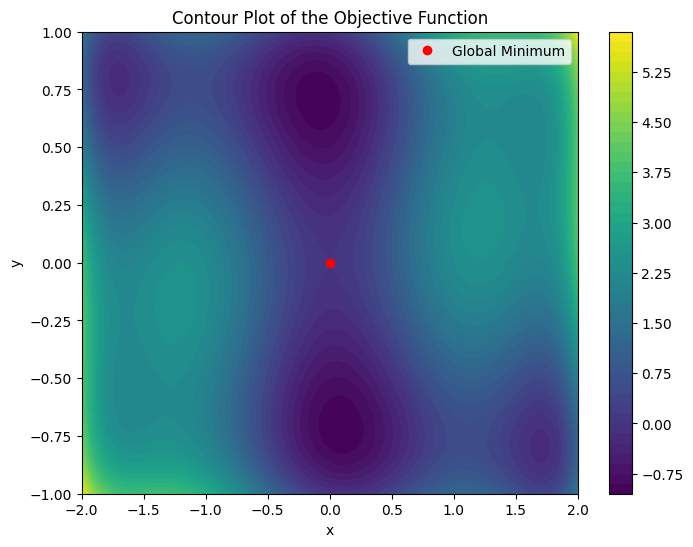

In [11]:
def objective_function(xy):
    x, y = xy
    return (4 - 2.1 * x**2 + x**4 / 3) * x**2 + x * y + (4 * y**2 - 4) * y**2

#Bounds for variables x and y
bounds = [(-2, 2), (-1, 1)]

#Grid of points for visualization
x_values = np.linspace(-2, 2, 400)
y_values = np.linspace(-1, 1, 200)
x_mesh, y_mesh = np.meshgrid(x_values, y_values)
z_mesh = objective_function([x_mesh, y_mesh])

#Contour plot of the function
plt.figure(figsize=(8, 6))
plt.contourf(x_mesh, y_mesh, z_mesh, levels=50, cmap='viridis')
plt.colorbar()
plt.title('Contour Plot of the Objective Function')
plt.xlabel('x')
plt.ylabel('y')

#Global minima using scipy.optimize.minimize
initial_guess = [0, 0]
result = minimize(objective_function, initial_guess, bounds=bounds)

#Global minimum
print("Global Minimum Found:")
print("x =", result.x[0])
print("y =", result.x[1])
print("Function Value at Global Minimum:", result.fun)

#Global minimum
plt.plot(result.x[0], result.x[1], 'ro', label='Global Minimum')

plt.legend()
plt.show()


2\. **Non-linear ODE: the damped pendulum**

The equation of the motion of a forced pendulum, as a function of the angle $\theta$ with the vertical, is given by:

$$\frac{d^2\theta}{dt^2} = -\frac{1}{Q} \frac{d\theta}{dt} + \frac{g}{l}\sin\theta + d \cos\Omega t$$

where $t$ is time, $Q$ is the damping factor, $d$ is the forcing amplitude, and $\Omega$ is the driving frequency of the forcing. 

This second order ODE needs to be written as two coupled first order ODEs by defining a new variable $\omega \equiv d\theta/dt$:

$$\frac{d\theta}{dt} = \omega$$
$$\frac{d\omega}{dt} = -\frac{1}{Q}\,\omega + \frac{g}{l}\sin\theta + d \cos\Omega t$$

Consider the initial conditions $\theta_0 = \omega_0 = 0$, and $l = 10$, $Q = 2.0$, $d = 1.5$, and $\omega = 0.65$.

 - Solve the ODE with `odeint` over a period of 200 time steps
 - Create two plots, one of $\theta$ as a function of the time, and $\omega$ as a function of the time
 - **Optional**: determine if there is a set of parameters for which the motion is chaotic.

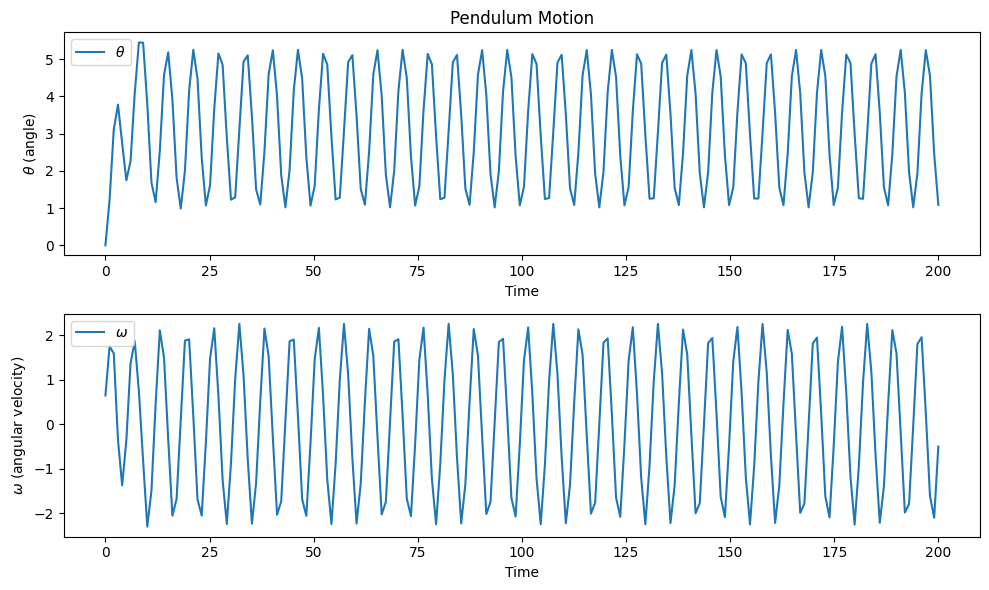

In [12]:
#Function that returns d(theta)/dt and d(omega)/dt
def pendulum_equations(y, t, Q, g, l, d, Omega):
    theta, omega = y
    dydt = [omega, -1/Q * omega + (g/l) * np.sin(theta) + d * np.cos(Omega * t)]
    return dydt

#Initial conditions
initial_conditions = [0, 0.65]  # theta_0 = 0, omega_0 = 0.65

#Parameters
l = 10.0
Q = 2.0
g = 9.81
d = 1.5
Omega = 1.0

#Time grid
t = np.linspace(0, 200, 200)

#ODE
solution = odeint(pendulum_equations, initial_conditions, t, args=(Q, g, l, d, Omega))

#Theta and omega from the solution
theta, omega = solution.T

plt.figure(figsize=(10, 6))

#Plot theta as a function of time
plt.subplot(2, 1, 1)
plt.plot(t, theta, label=r'$\theta$')
plt.title('Pendulum Motion')
plt.xlabel('Time')
plt.ylabel(r'$\theta$ (angle)')
plt.legend()

#Plot omega as a function of time
plt.subplot(2, 1, 2)
plt.plot(t, omega, label=r'$\omega$')
plt.xlabel('Time')
plt.ylabel(r'$\omega$ (angular velocity)')
plt.legend()

plt.tight_layout()
plt.show()


3\. **FFT of a simple dataset**

Perform a periodicity analysis on the lynxs-hares population, i.e. determine what is the period of the population of these animals.

The dataset is the one downloaded at the beginning of Lecture 06:

 - `!wget https://www.dropbox.com/s/ebe1cnyd2gm836a/populations.txt -P data/`

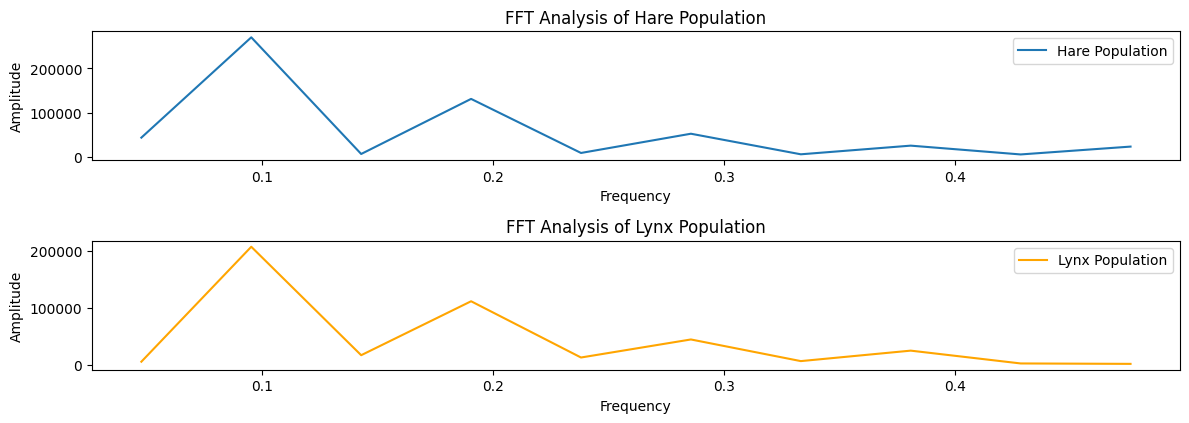

Period of Hare Population: 10.5 years
Period of Lynx Population: 10.5 years


In [15]:
data = np.loadtxt("data/populations.txt", skiprows=1)

time = data[:, 0]
hare_population = data[:, 1]
lynx_population = data[:, 2]

#Fast Fourier Transform (FFT) for hare and lynx populations
fft_hare = np.fft.fft(hare_population)
fft_lynx = np.fft.fft(lynx_population)

#Frequencies corresponding to FFT components
frequencies = np.fft.fftfreq(len(time), time[1] - time[0])

#Consider only positive frequencies
positive_frequencies_mask = frequencies > 0
frequencies = frequencies[positive_frequencies_mask]
fft_hare = fft_hare[positive_frequencies_mask]
fft_lynx = fft_lynx[positive_frequencies_mask]

plt.figure(figsize=(12, 6))

#FFT for hare population
plt.subplot(3, 1, 1)
plt.plot(frequencies, np.abs(fft_hare), label='Hare Population')
plt.title('FFT Analysis of Hare Population')
plt.xlabel('Frequency')
plt.ylabel('Amplitude')
plt.legend()

#FFT for lynx population
plt.subplot(3, 1, 2)
plt.plot(frequencies, np.abs(fft_lynx), label='Lynx Population', color='orange')
plt.title('FFT Analysis of Lynx Population')
plt.xlabel('Frequency')
plt.ylabel('Amplitude')
plt.legend()

plt.tight_layout()
plt.show()

#Indices of the maximum amplitudes in the FFT results
max_amplitude_index_hare = np.argmax(np.abs(fft_hare))
max_amplitude_index_lynx = np.argmax(np.abs(fft_lynx))

#Corresponding frequencies
dominant_frequency_hare = frequencies[max_amplitude_index_hare]
dominant_frequency_lynx = frequencies[max_amplitude_index_lynx]

#Check if dominant frequency is not zero before calculating period
if dominant_frequency_hare != 0:
    period_hare = 1 / abs(dominant_frequency_hare)
else:
    period_hare = np.inf

if dominant_frequency_lynx != 0:
    period_lynx = 1 / abs(dominant_frequency_lynx)
else:
    period_lynx = np.inf

print("Period of Hare Population:", period_hare, "years")
print("Period of Lynx Population:", period_lynx, "years")


4\. **FFT of an image**

Write a filter that removes the periodic noise from the `moonlanding.png` image by using a 2-dimensional FFT.

* Import the image as a 2D numpy array using `plt.imread("images/moonlanding.png")`. Examine the image with `plt.imshow()`, which is heavily contaminated with periodic noise.
* Check the documentation of the `scipy.fftpack` package, and find the method that performs a 2D FFT. Plot the spectrum (Fourier transform of) the image. **Hint**: use `LogNorm` to plot the colors in log scale:
```Python
from matplotlib.colors import LogNorm
plt.imshow(image, norm=LogNorm(vmin=5))
```
* Inspect the spectrum, and try to locate the 2D regions of the power spectrum that contain the signal and those which contain the periodic noise. Use array slicing to set the noise regions to zero.
* Apply the inverse Fourier transform to plot the resulting image.

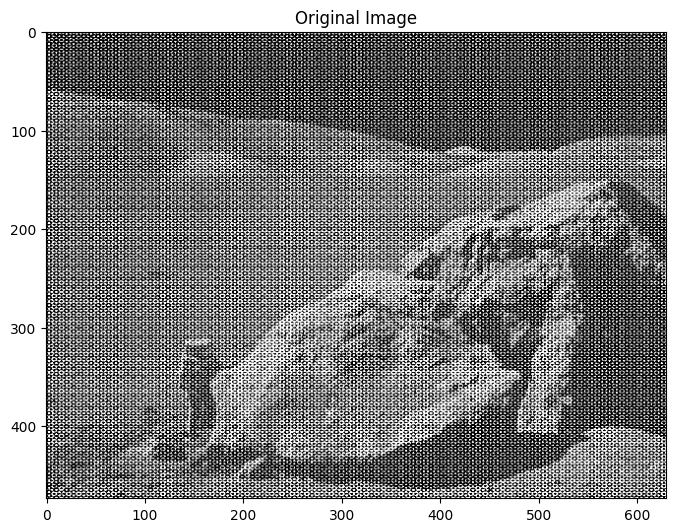

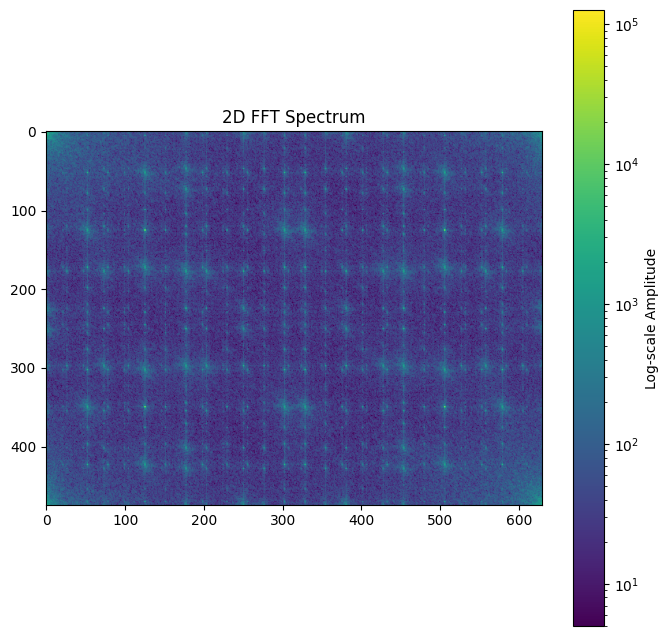

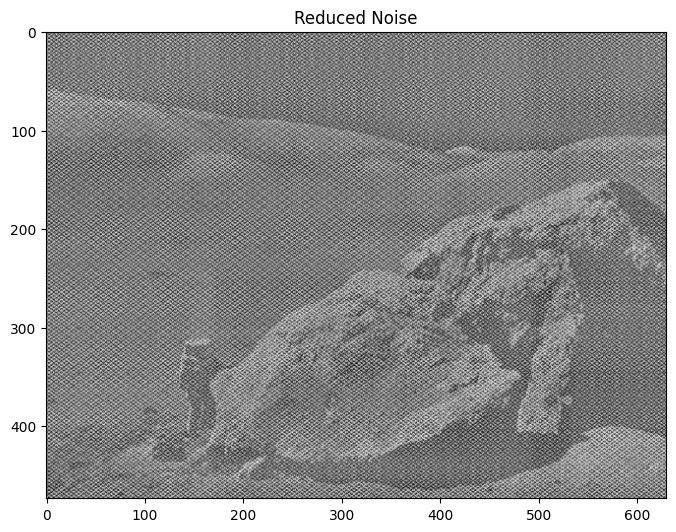

In [3]:
image = plt.imread("images/moonlanding.png")

plt.figure(figsize=(8, 8))
plt.imshow(image, cmap='gray')
plt.title('Original Image')
plt.show()

#2D FFT on the image
image_fft = fft2(image)

#Spectrum in log scale
plt.figure(figsize=(8, 8))
plt.imshow(np.abs(image_fft), norm=LogNorm(vmin=5))
plt.title('2D FFT Spectrum')
plt.colorbar(label='Log-scale Amplitude')
plt.show()


noise_threshold = 1  
image_fft[:noise_threshold, :] = 0
image_fft[-noise_threshold:, :] = 0
image_fft[:, :noise_threshold] = 0
image_fft[:, -noise_threshold:] = 0

#Inverse Fourier transform to get the denoised image
denoised_image = np.real(ifft2(image_fft))

plt.figure(figsize=(8, 8))
plt.imshow(denoised_image, cmap='gray')
plt.title('Reduced Noise')
plt.show()
